In [1]:
import sys
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt

In [2]:
def toTime(tStr: str) -> float:
    tStr = tStr.strip()
    if 'ms' in tStr:
        return float(tStr[:-2]) / 1000

    return float(tStr[:-1])


When both using one core the sequential solution takes 3.66 seconds and the parallel solution takes 1.91 seconds

Thus there is a parallelization overhead of -47.862%


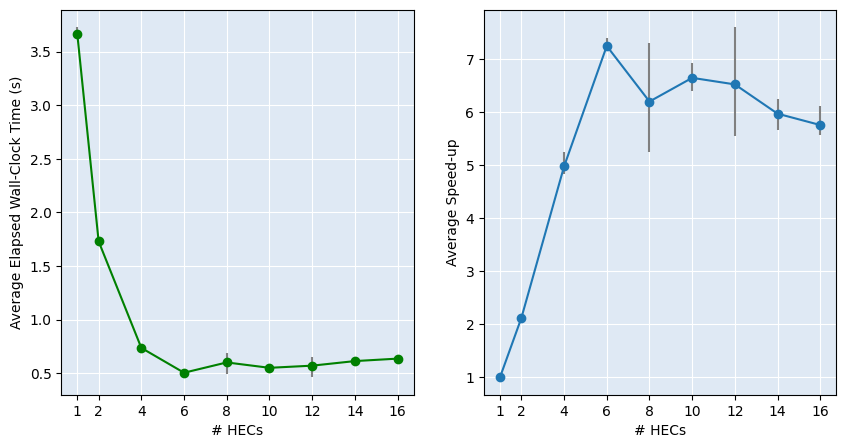

In [3]:
with open("results.txt") as reader:
  hecs_line = reader.readline()
  sequential_time_line = reader.readline()
  parallel_times_line = reader.readline()

  x = [ int(n) for n in hecs_line.split(' ') ]

  seq_times = [ toTime(t) for t in sequential_time_line.split(' ')]
  repeats = len(seq_times)

  times = parallel_times_line.split(" ")
  y = [
    [ toTime(times[j * len(x) + i]) for j in range(repeats) ]
    for i in range(len(x))
  ]

y = [ seq_times ] + y
y_avg = [ sum(ys) / repeats for ys in y ]

seq_time_avg = y_avg[0]
par_n1_time = y_avg[1]
del y[1]
del y_avg[1]

y_err = list(zip(*[
  [ max(ys) - y_avg, y_avg - min(ys) ]
  for y_avg, ys in zip(y_avg, y)
]))
speed_ups = [
  [ y[0][j] / y[i][j] for j in range(repeats) ]
  for i in range(len(x))
]
speed_up_avg = [ sum(xs) / repeats for xs in speed_ups ]
speed_up_err = list(zip(*[
  [ max(xs) - x_avg, x_avg - min(xs) ]
  for x_avg, xs in zip(speed_up_avg, speed_ups)
]))

print(f"\nWhen both using one core the sequential solution takes {seq_time_avg:.2f} seconds and the parallel solution takes {par_n1_time:.2f} seconds")
print("\nThus there is a parallelization overhead of", str(round(((par_n1_time/seq_time_avg)*100)-100, 3)) + "%")

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

for ax in [ax1, ax2]:
  ax.set_xticks(x)
  ax.set_xlabel("# HECs")
  ax.set_facecolor('#dfe9f4')
  ax.grid(color='white', linestyle='-')

ax1.set_ylabel("Average Elapsed Wall-Clock Time (s)")
ax2.set_ylabel("Average Speed-up")

ax1.errorbar(x, y_avg, yerr=y_err, fmt='go-', ecolor='gray')
ax2.errorbar(x, speed_up_avg, yerr=speed_up_err, fmt='o-', ecolor='gray')

plt.savefig('par_perf', dpi=600)